## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [74]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 50
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pm_fitting import *
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [75]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [76]:
# One-day download from John Hopkins Hospital database
day = 20
month = 3
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv/0{month}-{zero}{day}-2020.csv')

In [77]:
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
#df['update_date'] = df.updated.apply(lambda row: pd.to_datetime(f'{str(row)[0:4]}{str(row)[5:7]}{str(row)[8:10]}', format='%Y%m%d'))

df0 = df.copy() # temp

In [78]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands', 'French Polynesia', 'Saint Barthelemy', 'St Martin']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'DC'
        if state == "Virgin Islands, U.S.":
            s = 'VI'
        elif state.find(', ') > 0:
            s = state[state.find(', ')+2:state.find(', ')+4]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'      
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']
df = df[allcols]
df = df.reset_index(drop=True)

In [79]:
# country = 'France'
# data = df[df.state==country][:15]
# display(data)
# for col in [data.updated, data.date]:
#     fig, ax = plt.subplots()
#     plt.plot(col, data.new_confirmed)
#     ax.set_title(col.name)
#     plt.show()

In [80]:
# Country-level data
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1.shape
df1 = df1.sort_values(['date','confirmed'], ascending=False)
df1 = df1[['date','country'] + allcols[-6:]]
df1 = df1.set_index('date')

### 2. Analyse latest data


Top 20 countries by total cases as of 20/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-20,China,81250,3253,71266,88,4,731
2020-03-20,Italy,47021,4032,4440,5986,627,0
2020-03-20,Spain,20410,1043,1588,2447,213,481
2020-03-20,Germany,19848,67,180,4528,23,67
2020-03-20,Iran,19644,1433,6745,1142,149,1035
2020-03-20,United States,19101,244,147,5427,44,39
2020-03-20,France,12674,450,12,1748,207,0
2020-03-20,South Korea,8652,94,1540,120,3,0
2020-03-20,Switzerland,5294,54,15,1219,13,0



New confirmed cases from 1/2/2020 to 20/3/2020


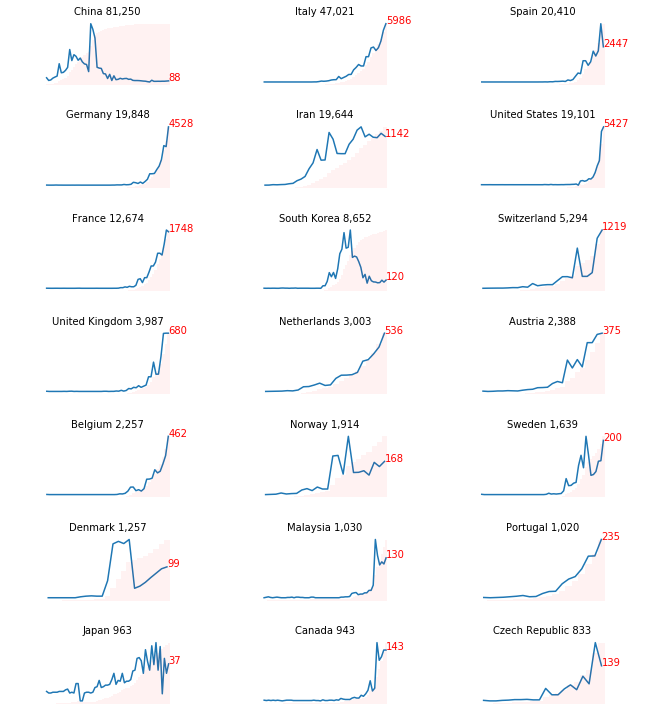

In [82]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

latest = df1.loc[date]
print(f'\nTop 20 countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:22])

# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:22].country)
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(9,10), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until, cdata.loc[until].new_confirmed, cdata.loc[until].new_confirmed, color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.savefig('top20.png')
plt.show()

In [83]:
df2 = df1[['country', 'confirmed', 'new_confirmed']].sort_index().reset_index()
dftemp = pd.DataFrame()
for country in df2.country.unique():
    dfc = df2[df2.country==country].copy().reset_index(drop=True)
    dfc['growth'] = 0
    dfc['new_growth'] = 0
    for i in range(1,len(dfc.index)):
        for newcol in ['growth', 'new_growth']:
            oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
            dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol]-1,2)
    dftemp =  pd.concat([dftemp, dfc])
df2 = dftemp[dftemp.confirmed > 50] # ignore cases below 50
df2 = df2.reset_index(drop=True)

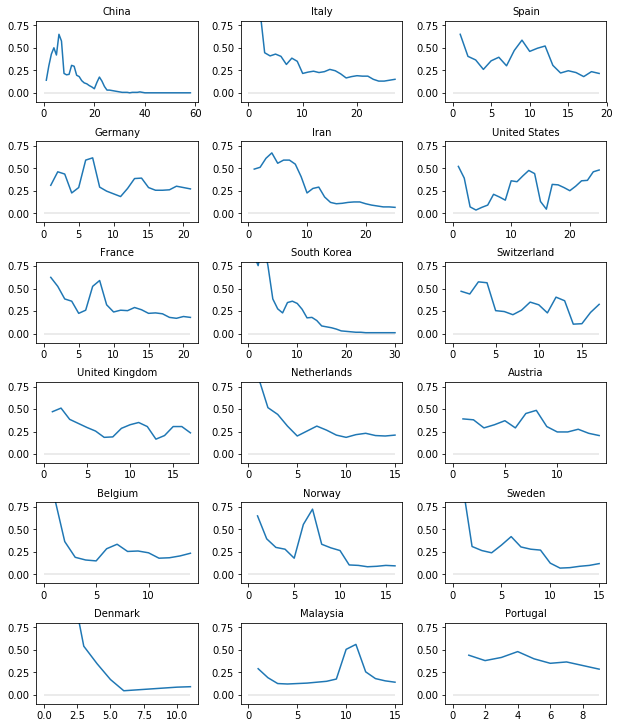

In [84]:
countries = list(latest[:18].country)
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(8.5,10), constrained_layout=True)
col = ['growth']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].reset_index(drop=True)
    ax.plot(data[col].rolling(window=2).mean())
    ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.set_ylim(-0.1, 0.8)
    ax.set_title(countries[i], fontsize=10)
plt.show()

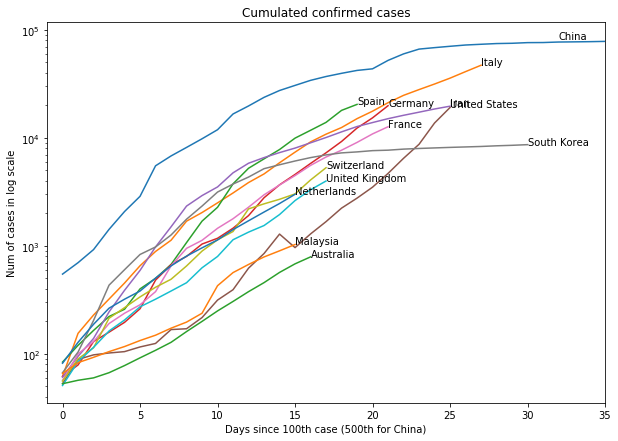

In [106]:
fig, ax = plt.subplots(figsize=(10,7))
for country in list(latest[:11].country) + ['Malaysia','Australia']:
    data = df2.loc[(df2.country==country) & (df2.confirmed > 0), 'confirmed'].reset_index(drop=True)
#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    plt.plot(data, label=country)
    xmax = 35
    plt.text(xmax-3 if country=='China' else data.index.max(), data.max(), country)
plt.yscale('log')
ax.set_title('Cumulated confirmed cases')
ax.set_xlim(-1, xmax)
ax.set_ylabel('Num of cases in log scale')
ax.set_xlabel('Days since 100th case (500th for China)')
plt.show()

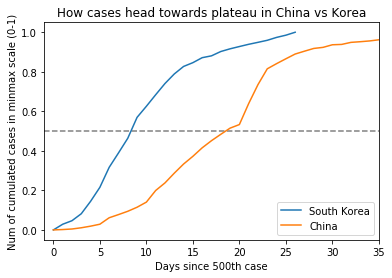

In [86]:
fig, ax = plt.subplots()
for country in ['South Korea','China']:
    data = df2.loc[(df2.country==country) & (df2.confirmed > 500), 'confirmed'].reset_index(drop=True)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    plt.plot(data, label=country)
xmax = 35
plt.hlines(0.5,-1, xmax, linestyle='dashed', alpha=0.5)
#plt.yscale('log')
ax.set_title('How cases head towards plateau in China vs Korea')
ax.set_xlim(-1, xmax)
ax.set_ylabel('Num of cumulated cases in minmax scale (0-1)')
ax.set_xlabel('Days since 500th case')
plt.legend(loc='lower right')
plt.show()

### Forecasting

In [115]:
# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to curve and plot prediction
def predict(country, rolling=1, days=110, showzero=True, df2=df2):
    dates = df2.loc[df2.country==country].reset_index(drop=True).date
    actual0 = df2.loc[df2.country==country, 'confirmed']
    actual = actual0.rolling(window=rolling).mean().reset_index(drop=True).drop(range(rolling)) if rolling > 0 else actual0.reset_index(drop=True)

    xdata = np.array(range(rolling,len(actual)+rolling))
    ydata = np.array(actual.values)
    popt, pcov = curve_fit(richards, xdata, ydata)
    A, K, C, Q, B, v = popt

    xdata2 = np.array(range(days))
    predict = richards(xdata2, A, K, C, Q, B, v).astype('int')
    latestdate = dates.iloc[-1]

    temp = pd.DataFrame(predict, index=range(actual.index.min(), len(predict)+actual.index.min())).diff().drop(actual.index.min())
    temp = temp.iloc[actual.index.max():]
    if np.isnan(temp[temp[0]==0].index.min()):
        showzero = False
    else:
        zerocase = temp[temp[0]==0].index.min()
        to_go_weeks = int(round((zerocase-len(actual))/7))
        oneday = pd.Timedelta(1, unit='days')
        zerodate = latestdate + oneday * to_go_weeks * 7

    fig, ax = plt.subplots()
    plt.plot(xdata2, richards(xdata2, A, K, C, Q, B, v), ls='dashed', c='#ff7f0e', label='Forecast')
    plt.plot(actual, c='#1f77b4', label='Actual to date')
    plt.scatter(actual.index[-1], int(actual.iloc[-1]), c='#1f77b4')
    plt.text(actual.index[-1], actual.iloc[-1], f'{latestdate.day}/{latestdate.month}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
    if showzero==True:
        plt.scatter(zerocase, predict.max(), c='#ff7f0e')
        predictmax = predict.max() if predict.max() > actual.iloc[-1] else actual.iloc[-1]
        plt.text(zerocase, predictmax, f'{zerodate.day}/{zerodate.month}\n{format(predictmax, ",")} cases', va='top')
    ax.set_title(country)
    ax.set_ylabel('Num of cumulative cases')
    ax.set_xlabel('Days since 100th case')
    plt.legend(loc='lower right')
    plt.show()

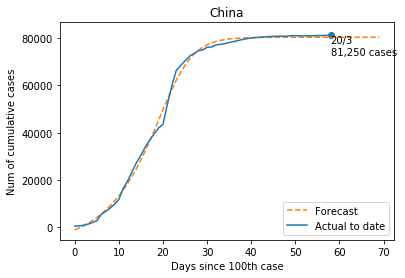

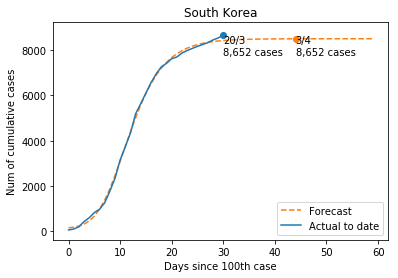

In [116]:
predict('China', rolling=0, days=70, showzero=False)
predict('South Korea', rolling=0, days=60)

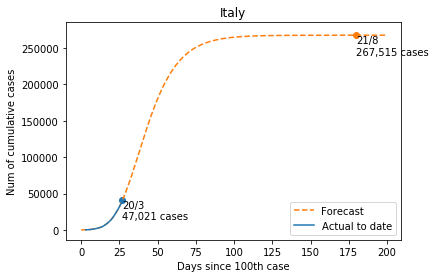

In [104]:
predict('Italy', rolling=3, days=200)

In [ ]:
predict('United Kingdom', rolling=1, days=90)

In [ ]:
predict('Iran', rolling=5, days=110)

In [ ]:
#predict('United States', rolling=3, showzero=False)
#predict('Australia', rolling=0, days=60, showzero=False)


In [ ]:
# country='Australia'
# rolling=0
# days=60
# showzero=True